<a href="https://colab.research.google.com/github/ArturGuilherme/tcc-avaliacao-classificadores/blob/master/performance_modelos_tcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das bibliotecas e upload do dataset

## Blibliotecas


In [ ]:
import tensorflow.keras as keras
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from keras.models import model_from_json

import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, RepeatedStratifiedKFold 
from sklearn.metrics import accuracy_score, classification_report, precision_score, \
confusion_matrix, plot_confusion_matrix, multilabel_confusion_matrix,recall_score,f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc,roc_auc_score

from sklearn.preprocessing import label_binarize, StandardScaler, OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import plotly
plotly.io.renderers.default = 'colab'
import plotly.graph_objects as go
import plotly.express as px

## Datasets


### Datasets train

In [ ]:
columns = ['Concentração de entrada','Vazão de entrada','Temperatura de entrada','Nível do Reator','Concentração de Produto A',\
        'Concentração de Produto B','Temperatura do Reator','Vazão de Refrigerante','Vazão de Produto','Temperatura Refrigerante',\
        'Pressão Refrigerante','Sinal de Controle Nível','Sinal de Controle de Vazão','Setpoint Controle Vazão','status']

#Importação do arquivo de Train
df_train =  pd.read_csv('https://raw.githubusercontent.com/ArturGuilherme/tcc-avaliacao-classificadores/master/data/baseCompleta.csv',names=columns,sep=';',decimal='.')

#balanceamento da classe de status 0
df_status_0 = df_train[df_train['status']==0].sample(n=1010,random_state=42)
df_status_dif_0 = df_train[df_train['status']!=0]

df_train = pd.concat([df_status_0,df_status_dif_0],ignore_index=True)


#Teste da im portação
df_train.head()

Concentração de entrada  Vazão de entrada  ...  Setpoint Controle Vazão  status
0                   19.990           0.24899  ...                  0.89661       0
1                   20.071           0.24607  ...                  0.88775       0
2                   19.809           0.25262  ...                  0.90914       0
3                   20.085           0.24911  ...                  0.89798       0
4                   19.640           0.25136  ...                  0.89627       0

[5 rows x 15 columns]

In [ ]:
df_train.shape

(18180, 15)

### Datasets test

In [ ]:
#Importação do arquivo de test
df_test_17 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TCC/datasets/CSTR/operacao_normal_falha17_test.csv',sep=';',decimal='.')
df_test_17.data = pd.to_datetime(df_test_17['data'],format="%d/%m/%Y %H:%M")
print(df_test_17['data'].min())
print(df_test_17['data'].max())
#Teste da importação
df_test_17.reset_index(inplace=True,drop=True)
df_test_17.head()

In [ ]:
#Importação do arquivo de test
df_test_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TCC/datasets/CSTR/operacao_normal_falha2_test.csv',sep=';',decimal='.')
df_test_2.data = pd.to_datetime(df_test_2['data'],format="%d/%m/%Y %H:%M")
print(df_test_2['data'].min())
print(df_test_2['data'].max())
#Teste da importação
df_test_2.reset_index(inplace=True,drop=True)
df_test_2.head()

2021-02-10 00:00:00
2021-02-12 02:00:00


Concentração de entrada  Vazão de entrada  ...  Falha                data
0                   19.771           0.24721  ...      1 2021-02-10 00:00:00
1                   19.866           0.25057  ...      1 2021-02-10 00:10:00
2                   19.995           0.25329  ...      1 2021-02-10 00:20:00
3                   20.029           0.25328  ...      1 2021-02-10 00:30:00
4                   20.096           0.25287  ...      1 2021-02-10 00:40:00

[5 rows x 16 columns]

In [ ]:
#Importação do arquivo de test
df_test_3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TCC/datasets/CSTR/operacao_normal_falha3_test.csv',sep=';',decimal='.')
df_test_3.data = pd.to_datetime(df_test_3['data'],format="%d/%m/%Y %H:%M")
print(df_test_3['data'].min())
print(df_test_3['data'].max())
#Teste da importação
df_test_3.reset_index(inplace=True,drop=True)
df_test_3.head()

2021-03-02 17:30:00
2021-03-04 19:30:00


Concentração de entrada  Vazão de entrada  ...  Falha                data
0                   19.782           0.24926  ...      1 2021-03-02 17:30:00
1                   19.996           0.25256  ...      1 2021-03-02 17:40:00
2                   19.920           0.24681  ...      1 2021-03-02 17:50:00
3                   19.889           0.24999  ...      1 2021-03-02 18:00:00
4                   19.928           0.25103  ...      1 2021-03-02 18:10:00

[5 rows x 16 columns]

In [ ]:
#Importação do arquivo de test
df_test_13 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TCC/datasets/CSTR/operacao_normal_falha13_test.csv',sep=';',decimal='.')
df_test_13.data = pd.to_datetime(df_test_13['data'],format="%d/%m/%Y %H:%M")
print(df_test_13['data'].min())
print(df_test_13['data'].max())
#Teste da importação
df_test_13.reset_index(inplace=True,drop=True)
df_test_13.head()

2021-03-20 00:10:00
2021-03-22 02:10:00


Concentração de entrada  Vazão de entrada  ...  Falha                data
0                   19.787           0.25193  ...      1 2021-03-20 00:10:00
1                   20.065           0.25088  ...      1 2021-03-20 00:20:00
2                   20.102           0.25096  ...      1 2021-03-20 00:30:00
3                   19.899           0.25175  ...      1 2021-03-20 00:40:00
4                   19.974           0.24863  ...      1 2021-03-20 00:50:00

[5 rows x 16 columns]

In [ ]:
df_test = df_test_13.copy()

# Análise Exploratória dos dados

## Dados missing e duplicados

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204 entries, 0 to 1203
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Concentração de entrada     1204 non-null   float64       
 1   Vazão de entrada            1204 non-null   float64       
 2   Temperatura de entrada      1204 non-null   float64       
 3   Nível do Reator             1204 non-null   float64       
 4   Concentração de Produto A   1204 non-null   float64       
 5   Concentração de Produto B   1204 non-null   float64       
 6   Temperatura do Reator       1204 non-null   float64       
 7   Vazão de Refrigerante       1204 non-null   float64       
 8   Vazão de Produto            1204 non-null   float64       
 9   Temperatura Refrigerante    1204 non-null   float64       
 10  Pressão Refrigerante        1204 non-null   int64         
 11  Sinal de Controle Nível     1204 non-null   float64     

Dataset sem dados missing. Todos as features possuem 51170 amostras

In [ ]:
# Removendo as amostras duplicadas para que não ter problema de overfit
print(df_train.shape)
subset = df_train.columns[0:14]
df_train.drop_duplicates(subset=subset, inplace=True)
print(df_train.shape)

(1204, 16)
(1204, 16)


Sem amostras duplicadas

## Visualização das features

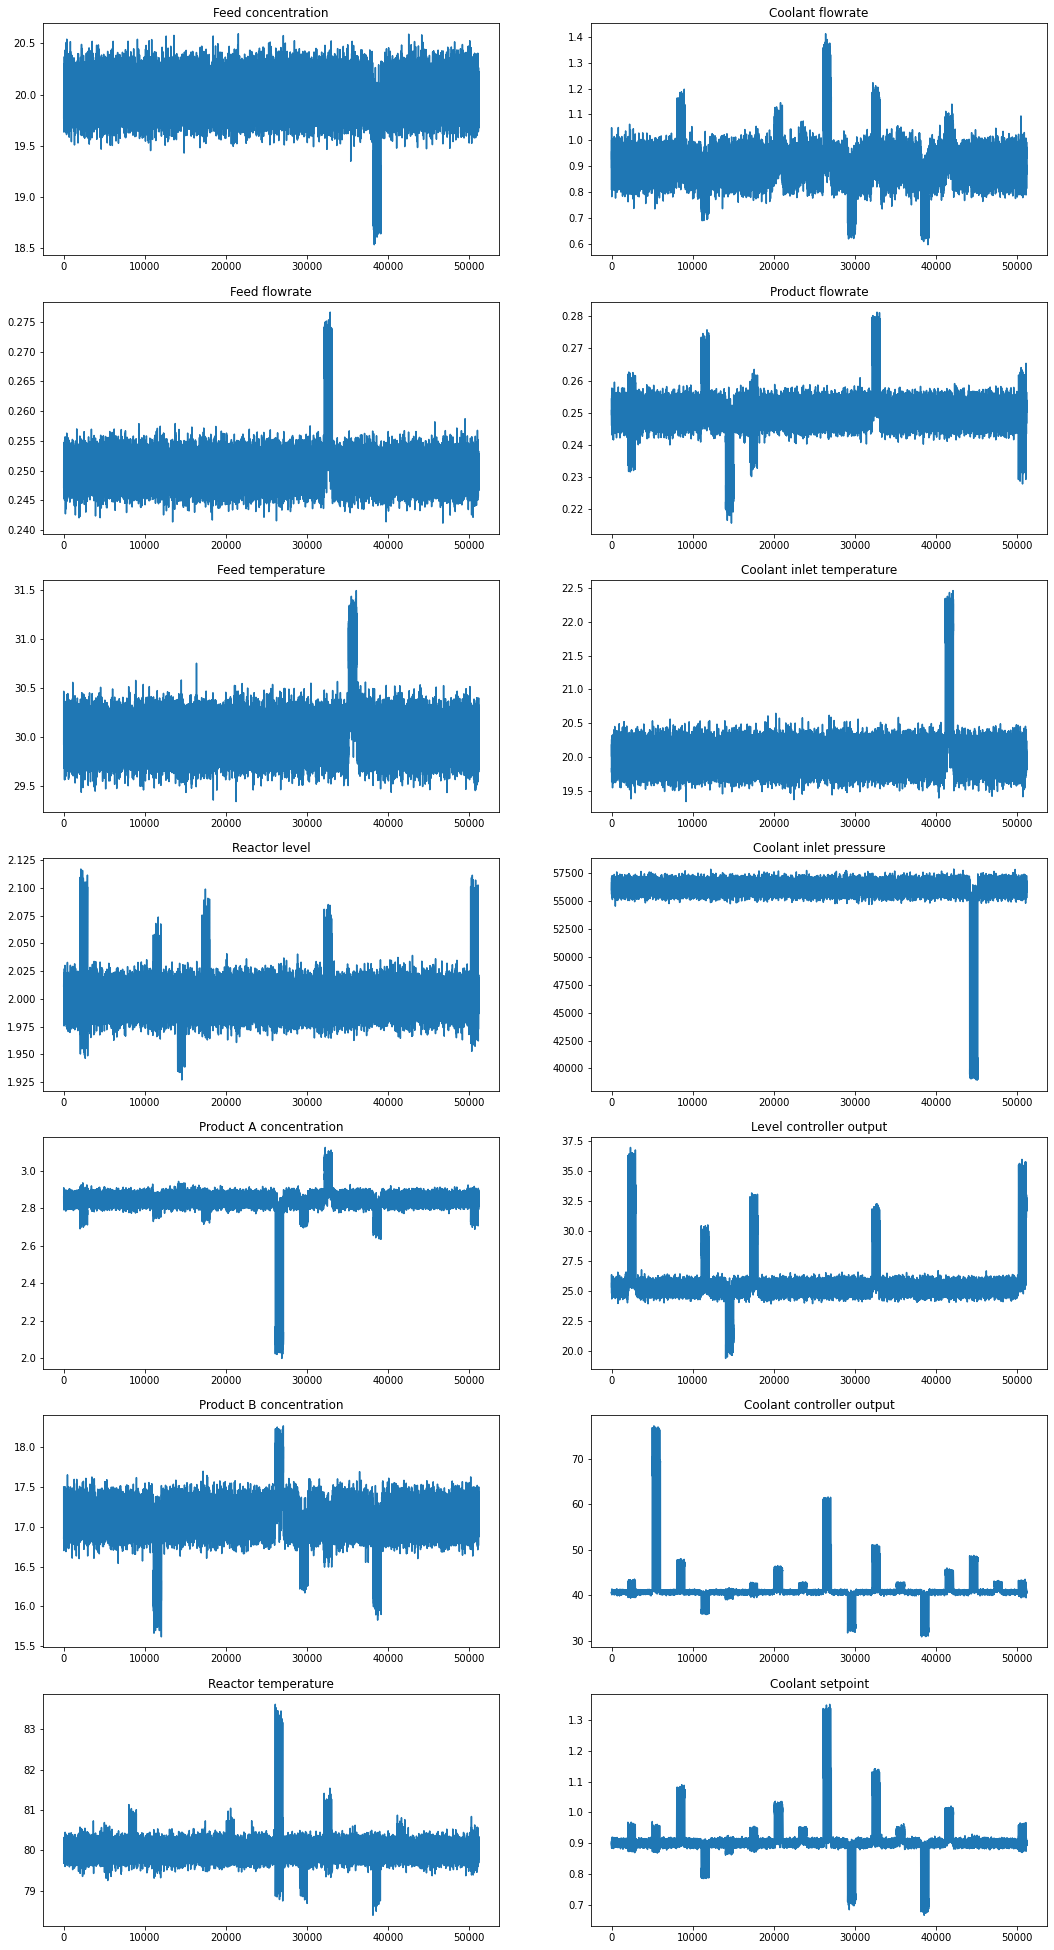

In [ ]:
#Visualizacao das features
df_aux = df_train.copy()
eixoX=list(range(len(df_aux)))
cols = list(df_aux.columns)
aux = 0
fig, axs = plt.subplots(7,2, figsize=(18, 35))
for x in range(0,2):
  for i in range(0,7):
    axs[i,x].plot(eixoX,df_aux.iloc[:,aux])
    axs[i,x].set_title(cols[aux])
    aux = aux+1

In [ ]:
# Visualização normalizada
df_aux = df_train.copy()
df_aux.drop(columns=['status'],inplace=True)

tamanho = df_aux.shape

x1 = list(range(tamanho[0]))
start = 0
end = 1

fig = go.Figure()

colunas = df_aux.columns

for x in range(tamanho[1]):
  arr = df_aux.iloc[:, x]
  width = end - start
  res = (arr - arr.min())/np.ptp(arr) * width + start

  fig.add_trace(go.Scatter(x=x1, y=res, mode='lines', name=colunas[x]))

  start = start+1
  end = end+1


fig.update_layout(
    title='Variáveis Normalizadas',
    title_font_color = '#333333', # Grey is always better to not draw much attention
    title_font_size = 14,
    xaxis_title = 'Instante de tempo',
    yaxis_title = 'Variáveis'
    )

fig.show()


In [ ]:
# Grafico de correlação
df_train.corr().style.background_gradient().set_precision(2)

Não há feature que esteja muito correlacionada com o target. "Temperatura refrigerante" e "Sinal de nivel de controle" são as que mais se destacam.

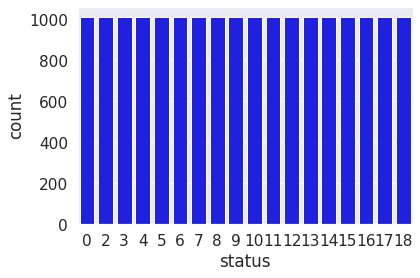

In [ ]:
#Anlise da distruibuição dos rotulos 
sns.countplot(df_train['status'], color='blue');

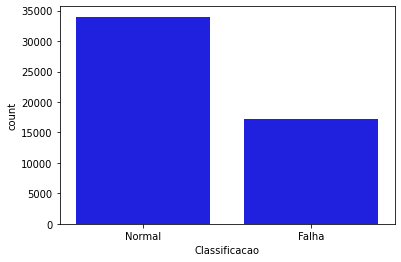

In [ ]:
df_aux = df_train.copy()
df_aux['Classificacao'] = 0
for index,row in df_aux.iterrows():
  if row['status'] != 0:
    wdf_aux.Classificacao.loc[index] = 'Falha'
  else:
    df_aux.Classificacao.loc[index] = 'Normal'
sns.countplot(df_aux['Classificacao'], color='blue');

## Balanceamento das classes

In [ ]:
dataset_falha_um = df_train[df_train['Falha']==1]
dataset_outras_falhas = df_train[df_train['Falha']!=1]

#Reduzindo em 30% de forma rondomica as amostras de falha 1 
df_reduzido, _ = train_test_split(dataset_falha_um,train_size=0.03, random_state=42)
df_reduzido = pd.concat([df_reduzido, dataset_outras_falhas], ignore_index=True)

#Separação da base treinameno e teste
X_train, X_test = train_test_split(df_reduzido,test_size=0.3, random_state=42)

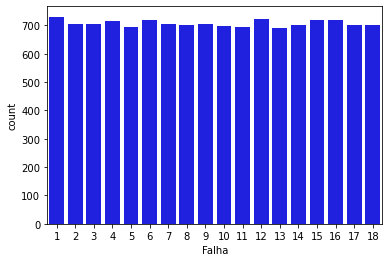

In [ ]:
#Base para treinar/validar modelo
sns.countplot(X_train['Falha'], color='blue');

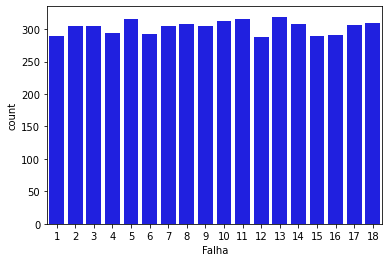

In [ ]:
#Base para testar
sns.countplot(X_test['Falha'], color='blue');

In [ ]:
#separação das features do rotulo
Y_train = X_train.Falha
X_train = X_train.drop("Falha",axis=1)
labels = sorted(list(dict.fromkeys(Y_train))) # Monta uma lista com os os rotulos, sem valores duplicados e de ordem crescente

In [ ]:
#scaling
scaler = StandardScaler()
columns = X_train.columns
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=columns)

# Train an Test

## 1º Opção

In [ ]:
scaler = StandardScaler()

Y_train = df_train.status.values
X_train = df_train.iloc[:,0:14].to_numpy()
X_train = scaler.fit_transform(X_train)

labels = sorted(list(dict.fromkeys(Y_train))) # Monta uma lista com os os rotulos, sem valores duplicados e de ordem crescente

X_train,X_valid,Y_train,Y_valid = train_test_split(X_train,Y_train,test_size=0.20,random_state=42)

y_valid_log = []
for val in Y_valid:
  if val != 0:
    y_valid_log.append(val-1)
  else:
    y_valid_log.append(val)

## 2º Opção

In [ ]:
#Train
Y_train = df_train.status
X_train = df_train.drop(columns =['status'], axis=1)
labels_train = sorted(list(dict.fromkeys(Y_train))) # Monta uma lista com os os rotulos, sem valores duplicados e de ordem crescente

#scaling
scaler = StandardScaler()
scaler.fit(X_train)
columns = X_train.columns
X_train = pd.DataFrame(scaler.transform(X_train),columns=columns)

In [ ]:
#Test
Y_test = df_test.status
X_test = df_test.drop(columns =['status'], axis=1)
labels_test = sorted(list(dict.fromkeys(Y_test))) # Monta uma lista com os os rotulos, sem valores duplicados e de ordem crescente

#scaling
columns = X_test.columns
X_test = pd.DataFrame(scaler.transform(X_test),columns=columns)

# Feature importance

Nessa etapa iremos reduzir a dimensionalidade do nosso dataset pela metade (apenas 7 features). Para isso iremos testar executar duas abordagens para seleção das features e avaliar qual trouxe melhor resultado.
XGBoost ou RFE. 


## XGBoost

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train,Y_train)
feature_importance = xgb.feature_importances_

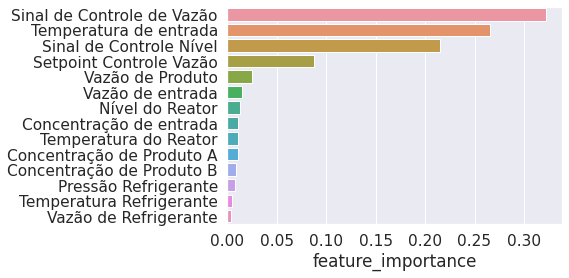

In [ ]:
df_fi_xgb = pd.DataFrame(feature_importance,index=columns,columns=["feature_importance"])
df_fi_xgb = df_fi_xgb.sort_values(by=['feature_importance'],ascending=False)
sns.barplot(x=df_fi_xgb['feature_importance'],y=df_fi_xgb.index,data=df_fi_xgb);

In [ ]:
X_train = X_train.loc[:,list(df_fi_xgb.iloc[0:4].index)]
X_test = X_test.loc[:,list(df_fi_xgb.iloc[0:4].index)]
X_train.head()

Sinal de Controle de Vazão  ...  Setpoint Controle Vazão
0                   -0.338135  ...                -0.235859
1                   -0.312300  ...                -0.143308
2                   -0.353227  ...                -0.010357
3                   -0.283140  ...                -0.487069
4                   -0.317416  ...                -0.614143

[5 rows x 4 columns]

## RFE - Recursive Feature Elimination

In [ ]:
model = LinearSVC()
rfe = RFE(model, step=1).fit(X_train, Y_train)

In [ ]:
X_train = X_train.loc[:,rfe.support_]
X_test = X_test.loc[:,rfe.support_]
X_train.head()

Temperatura de entrada  ...  Setpoint Controle Vazão
0               -0.266767  ...                -0.235859
1               -0.895032  ...                -0.143308
2               -0.609748  ...                -0.010357
3                0.457661  ...                -0.487069
4                0.255718  ...                -0.614143

[5 rows x 7 columns]

# Modelos


Os algoritmos a serem implementados são:
*   Naive Bayes
*   KNN (K-Nearest Neighbors)
*   Decision Trees
*   Random Forest
*   CNN ( Neural Network)




As métricas a serem avalidas são:


*   Acurácia
*   Precisão
*   Sensitivity/recall
*   Specificity
*   F1 Score
*   ROC Análysis
*   AUC





## Funções Gerais

In [ ]:
def metrica(modelo,X_train,Y_train,labels):

  acc_mclass = pd.DataFrame()
  pre_mclass = pd.DataFrame()
  spe_mclass = pd.DataFrame()
  rec_mclass = pd.DataFrame()
  fsco_mclass = pd.DataFrame()
  auc_roc_mclass = pd.DataFrame()
  metricas = pd.DataFrame()

  # Validaçao cruzada
  # Definição de 5 splits para 30 repetições
  rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
  for linhas_treino, linhas_valid in rkf.split(X_train,Y_train):

    x_treino, x_valid = X_train[linhas_treino],X_train[linhas_valid]
    y_treino, y_valid = Y_train[linhas_treino],Y_train[linhas_valid]

    #Treinamento do modelo
    modelo.fit(x_treino,y_treino)
    y_predict = modelo.predict(x_valid)

    cm_multiclass = multilabel_confusion_matrix(y_valid,y_predict,labels=labels)

    acc_aux,pre_aux,spe_aux,rec_aux,fsco_aux,auc_roc_aux = metrics_confusion_matrix(cm_multiclass)
    
    acc_aux = pd.DataFrame(acc_aux)
    pre_aux = pd.DataFrame(pre_aux)
    spe_aux = pd.DataFrame(spe_aux)
    rec_aux = pd.DataFrame(rec_aux)
    fsco_aux = pd.DataFrame(fsco_aux)
    auc_roc_aux = pd.DataFrame(auc_roc_aux)

    # No final será gerado uma matriz com 150 registros de cada tipo de falha
    acc_mclass = pd.concat([acc_mclass,acc_aux.T],ignore_index=True)
    #print(acc_mclass)
    pre_mclass = pd.concat([pre_mclass,pre_aux.T],ignore_index=True)
    spe_mclass = pd.concat([spe_mclass,spe_aux.T],ignore_index=True)
    rec_mclass = pd.concat([rec_mclass,rec_aux.T],ignore_index=True)
    fsco_mclass = pd.concat([fsco_mclass,fsco_aux.T],ignore_index=True)

  acc_mclass = pd.DataFrame(list(acc_mclass.mean()),columns=['Acuracia'])
  metricas = pd.concat([metricas,acc_mclass],axis=1)

  pre_mclass = pd.DataFrame(list(pre_mclass.mean()),columns=['Precisão'])
  metricas = pd.concat([metricas,pre_mclass],axis=1)

  spe_mclass = pd.DataFrame(list(spe_mclass.mean()),columns=['Specificity'])
  metricas = pd.concat([metricas,spe_mclass],axis=1)

  rec_mclass = pd.DataFrame(list(rec_mclass.mean()),columns=['Recall/Sensitivity'])
  metricas = pd.concat([metricas,rec_mclass],axis=1)

  fsco_mclass = pd.DataFrame(list(fsco_mclass.mean()),columns=['F1Score'])
  metricas = pd.concat([metricas,fsco_mclass],axis=1)

  ### Setando o indice com os labels das falhas
  metricas.set_index(pd.Index(labels),inplace=True)
  return metricas

# Gera as metricas
def metrics_confusion_matrix(cm_multiclass):
   
  acc = []
  pre = [] 
  spe = []
  rec = []
  fsco = []
  auc_roc = []

  cont = 0

  for cm in cm_multiclass:
    
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    TP = cm[1,1]

    #Acuracia
    acc.append((TP+TN)/(TP+FP+FN+TN))

    #Precisão
    pre.append(TP/(TP+FP))

    #𝑆𝑝𝑒𝑐𝑖𝑓𝑖𝑐𝑖𝑡𝑦
    spe.append(TN/(TN+FN))

    #recall = S𝑒𝑛𝑠𝑖𝑡𝑖𝑣𝑖𝑡𝑦
    rec.append(TP/(TP+FN))

    #F1 Score
    fsco.append(2*((rec[cont]*pre[cont])/(rec[cont]+pre[cont])))

    cont = cont+1

  return acc,pre,spe,rec,fsco,auc_roc

## Naive Bayes

In [ ]:
nb_model = GaussianNB()
metrica_nb = metrica(nb_model,X_train,Y_train,labels)
metrica_nb

Acuracia  Precisão  Specificity  Recall/Sensitivity   F1Score
0   0.986208  0.979669     0.999914            0.999958  0.989709
2   0.979117  0.444264     0.986997            0.336722  0.382378
3   0.999414  1.000000     0.999403            0.969565  0.984469
4   0.995142  0.931080     0.996306            0.818444  0.870871
5   0.997711  0.998437     0.997698            0.886260  0.938859
6   0.996566  0.929187     0.997866            0.892989  0.910563
7   0.979675  0.497458     0.993708            0.695348  0.579579
8   0.997906  0.981573     0.998209            0.909897  0.944347
9   0.997962  0.951093     0.998946            0.949511  0.950141
10  0.999581  1.000000     0.999573            0.978793  0.989215
11  0.998855  0.998540     0.998863            0.942724  0.969675
12  0.999442  1.000000     0.999431            0.970940  0.985184
13  0.999386  1.000000     0.999374            0.968904  0.984162
14  0.999302  1.000000     0.999288            0.965374  0.982356
15  0.999693  1.000000     0.999687            0.984527  0.992170
16  0.999832  1.000000     0.999829            0.991837  0.995890
17  0.999414  0.998551     0.999431            0.971691  0.984910
18  0.976242  0.379464     0.985265            0.283666  0.321808

## KNN (K-Nearest Neighbors)

In [ ]:
knn_model = KNeighborsClassifier()
metrica_knn = metrica(knn_model,X_train,Y_train,labels)
metrica_knn

Acuracia  Precisão  Specificity  Recall/Sensitivity   F1Score
0   0.926151  0.899862     1.000000            1.000000  0.947290
2   0.975652  0.390336     0.988027            0.408455  0.399065
3   0.998092  0.962713     0.998781            0.938824  0.950521
4   0.976572  0.413878     0.988381            0.427040  0.420094
5   0.991861  0.908397     0.993073            0.655081  0.761024
6   0.989056  1.000000     0.988962            0.438622  0.609109
7   0.979629  0.480754     0.988739            0.438114  0.458306
8   0.976870  0.417840     0.989283            0.463529  0.439332
9   0.974249  0.285780     0.983731            0.194944  0.231691
10  0.992666  0.908520     0.993977            0.699619  0.790221
11  0.982549  0.568295     0.990212            0.517374  0.541319
12  0.994367  0.976139     0.994635            0.727170  0.832696
13  0.981147  0.573946     0.983957            0.196955  0.292938
14  0.983216  0.599293     0.989599            0.488506  0.537951
15  0.986619  0.751987     0.989615            0.479627  0.585213
16  0.999793  1.000000     0.999789            0.989862  0.994904
17  0.977560  0.347886     0.983318            0.159064  0.217813
18  0.975606  0.341279     0.984269            0.227704  0.272741

## Decision Trees

In [ ]:
clf_model = DecisionTreeClassifier()
metrica_clf = metrica(clf_model,X_train,Y_train,labels)
metrica_clf

Acuracia  Precisão  Specificity  Recall/Sensitivity   F1Score
0   0.971604  0.981545     0.952312            0.975618  0.978568
2   0.982744  0.561433     0.991405            0.573267  0.566891
3   0.999433  0.983255     0.999761            0.988119  0.985672
4   0.992222  0.785761     0.996687            0.835644  0.809386
5   0.995427  0.879979     0.997807            0.891089  0.885138
6   0.994860  0.858602     0.997726            0.887129  0.872170
7   0.993707  0.844112     0.996711            0.836634  0.840074
8   0.996932  0.924846     0.998386            0.919802  0.922058
9   0.996365  0.895647     0.998464            0.923762  0.909269
10  0.999570  0.991108     0.999741            0.987129  0.989089
11  0.997831  0.943426     0.998943            0.947525  0.945294
12  0.999257  0.975645     0.999741            0.987129  0.981314
13  0.998827  0.971447     0.999382            0.969307  0.970268
14  0.998730  0.961157     0.999501            0.975248  0.968091
15  0.999472  0.984265     0.999781            0.989109  0.986671
16  0.999570  0.988349     0.999801            0.990099  0.989150
17  0.998710  0.965766     0.999382            0.969307  0.967357
18  0.980731  0.512572     0.990250            0.515842  0.513752

## Random Forest

In [ ]:
rf_model = RandomForestClassifier(bootstrap=True,max_depth=80,max_features=1,min_samples_leaf=5,min_samples_split=12,n_estimators=200)
metrica_rf = metrica(rf_model,X_train,Y_train,labels)
metrica_rf

Acuracia  Precisão  Specificity  Recall/Sensitivity   F1Score
0   0.985832  0.979346     0.999514            0.999765  0.989449
2   0.983330  0.581598     0.991037            0.554455  0.567478
3   0.999648  1.000000     0.999641            0.982178  0.990997
4   0.995740  0.980615     0.995988            0.800000  0.881089
5   0.997694  1.000000     0.997653            0.883168  0.937870
6   0.996228  0.926283     0.997570            0.879208  0.902042
7   0.994274  0.885121     0.996298            0.815842  0.848748
8   0.997850  0.957462     0.998645            0.932673  0.944833
9   0.997948  0.964081     0.998606            0.930693  0.947023
10  0.999746  1.000000     0.999741            0.987129  0.993516
11  0.998964  0.996896     0.999004            0.950495  0.973126
12  0.999648  0.998010     0.999681            0.984158  0.991015
13  0.999433  0.997949     0.999462            0.973267  0.985423
14  0.999492  1.000000     0.999482            0.974257  0.986950
15  0.999785  1.000000     0.999781            0.989109  0.994516
16  0.999805  1.000000     0.999801            0.990099  0.995015
17  0.999218  0.983184     0.999542            0.977228  0.980113
18  0.981219  0.523958     0.990451            0.525743  0.524377

# Validação

## Funções Gerais

In [ ]:
def metricas(y_pred_prob,y_valid_log,classificador):
  y_pred = np.argmax(y_pred_prob,axis=1)
  for idx, val in enumerate(y_pred):
    if val != 0:
      y_pred[idx] = val+1

  ######## Metricas para cada rótulo #######
  cr = classification_report(Y_valid,y_pred,output_dict=True)
  df_por_rotulo = pd.DataFrame(cr).T
  df_por_rotulo.drop(df_por_rotulo.tail(3).index,inplace=True)
  df_por_rotulo.drop('support',axis=1,inplace=True)

  ######## Metricas globais do modelo conforme media de ponterada de cada rotulo ########
  acc = accuracy_score(Y_valid,y_pred)
  pre = precision_score(Y_valid,y_pred,average='macro')
  f1_s = f1_score(Y_valid,y_pred,average='macro')
  rec = recall_score(Y_valid,y_pred,average='macro')
  log = log_loss(y_valid_log,y_pred_prob)
  auc = roc_auc_score(y_valid_log,y_pred_prob, multi_class='ovr',average='macro')

  df_geral = pd.DataFrame([[acc,pre,f1_s,rec,log,auc]],columns=["Acurácia","Precisão","F1-Score","Recall","Log Loss","AUC"])

  ####### Matriz de Confusão multiclass
  cm = confusion_matrix(Y_valid,y_pred,labels)
  df_cm = pd.DataFrame(cm, index = labels,columns = labels)
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'

  ####### Data Frame para gráfico 
  df_por_rotulo_graf = df_por_rotulo.reset_index()
  df_por_rotulo_graf['Classificador'] = classificador
  df_por_rotulo_graf.drop(columns=['recall','precision'],axis=1,inplace=True)


  for i, row in df_por_rotulo_graf.iterrows():
      falha = row['index']
      if falha != '0':
        df_por_rotulo_graf['index'].loc[i] = "Falha "+str(falha)
      else:
        df_por_rotulo_graf['index'].loc[i] = 'Op. Normal'

  df_por_rotulo_graf = df_por_rotulo_graf.append(df_por_rotulo_graf.iloc[0])

  return df_geral,df_por_rotulo,df_cm,df_por_rotulo_graf

##  Naive Bayes

In [ ]:
######## Geração do Modelo ########
nb_model = GaussianNB()
nb_model.fit(X_train,Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
######## Predição do Modelo
y_pred_prob = nb_model.predict_proba(X_valid)
df_geral_nb, df_por_rotulo_nb, df_cm_nb,grafico_nb = metricas(y_pred_prob,y_valid_log,'Naive Bayes')

In [ ]:
df_geral_nb.to_csv("df_geral_nb.csv")

In [ ]:
df_por_rotulo_nb.to_csv("df_por_rotulo_nb.csv")

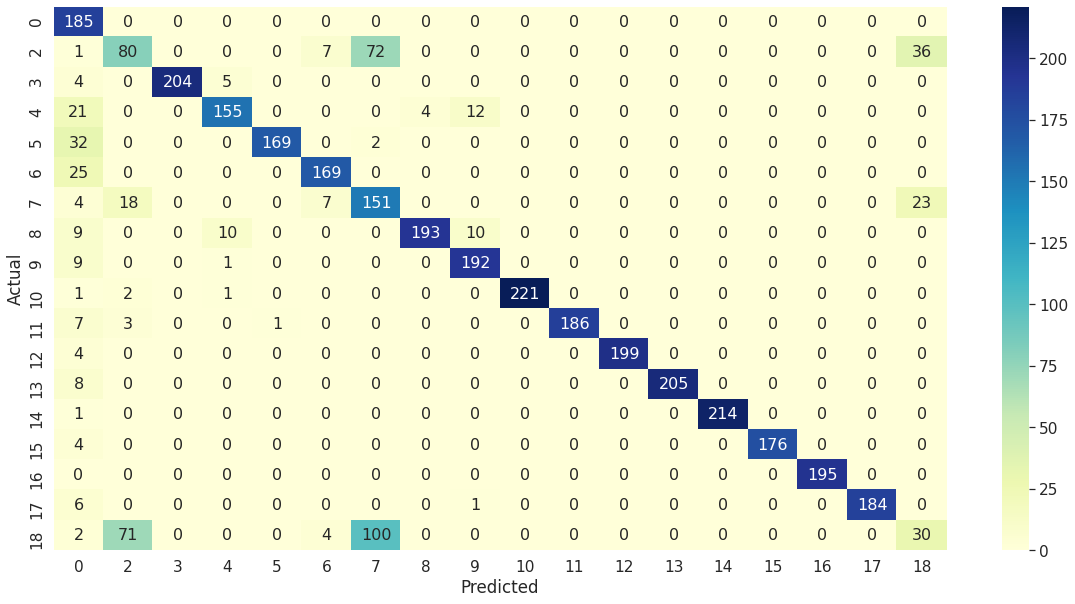

In [ ]:
plt.figure(figsize = (20,10))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm_nb, annot=True, annot_kws={"size": 16}, fmt="d",cmap="YlGnBu");

## KNN

In [ ]:
######## Geração do Modelo ########
knn_model = KNeighborsClassifier(n_neighbors=69)
knn_model.fit(X_train,Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=69, p=2,
                     weights='uniform')

In [ ]:
######## Predição ########
y_pred_prob = knn_model.predict_proba(X_valid)

df_geral_knn,df_por_rotulo_knn, df_cm_knn,grafico_knn = metricas(y_pred_prob,y_valid_log,'KNN')

In [ ]:
df_geral_knn.to_csv("df_geral_knn.csv")

In [ ]:
df_por_rotulo_knn.to_csv("df_por_rotulo_knn.csv")

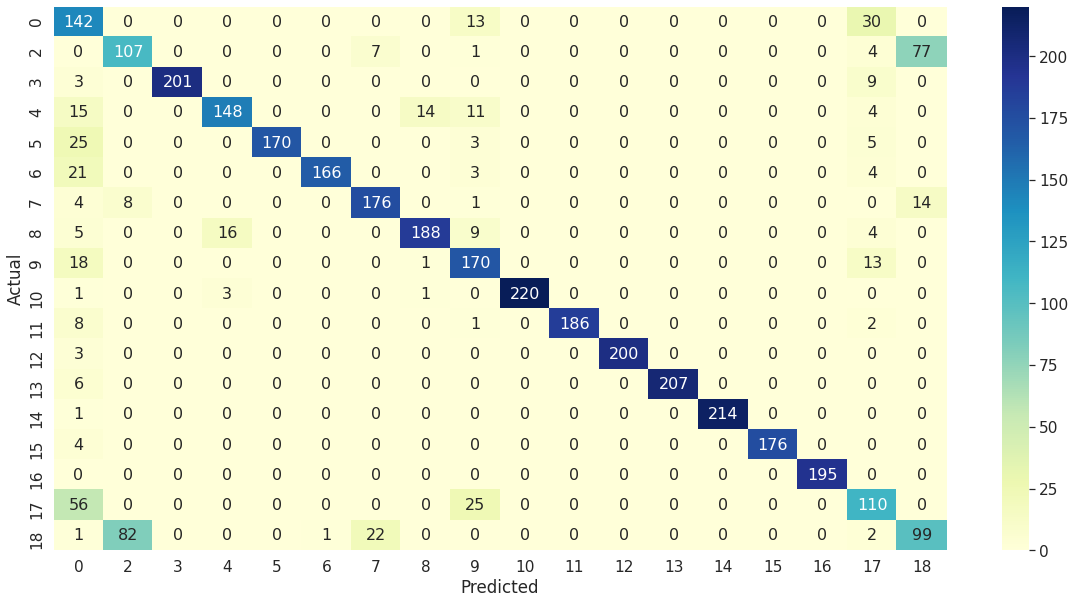

In [ ]:
plt.figure(figsize = (20,10))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm_knn, annot=True, annot_kws={"size": 16}, fmt="d",cmap="YlGnBu");

## Decision Trees

In [ ]:
######### 
clf_model = DecisionTreeClassifier(max_leaf_nodes=70,min_samples_split=5,max_depth=70)
clf_model.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=70, max_features=None, max_leaf_nodes=70,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
######## Prediação do modelo #########
y_pred_prob = clf_model.predict_proba(X_valid)

df_geral_dt, df_por_rotulo_dt, df_cm_dt,grafico_dt = metricas(y_pred_prob,y_valid_log,'Decision Trees')

In [ ]:
df_geral_dt

Acurácia  Precisão  F1-Score    Recall  Log Loss       AUC
0  0.906307  0.919032  0.908454  0.906307  0.418692  0.992116

In [ ]:
df_por_rotulo_dt

precision    recall  f1-score
0    0.588235  0.975610  0.733945
2    0.605556  0.726667  0.660606
3    1.000000  0.983713  0.991790
4    0.941406  0.833910  0.884404
5    0.992806  0.859813  0.921536
6    0.988095  0.861592  0.920518
7    0.885621  0.888525  0.887070
8    0.973333  0.918239  0.944984
9    0.944444  0.935275  0.939837
10   0.996855  0.990625  0.993730
11   1.000000  0.943522  0.970940
12   0.996441  0.992908  0.994671
13   0.996894  0.978659  0.987692
14   0.993691  0.990566  0.992126
15   1.000000  0.986348  0.993127
16   1.000000  1.000000  1.000000
17   0.992933  0.972318  0.982517
18   0.610860  0.457627  0.523256

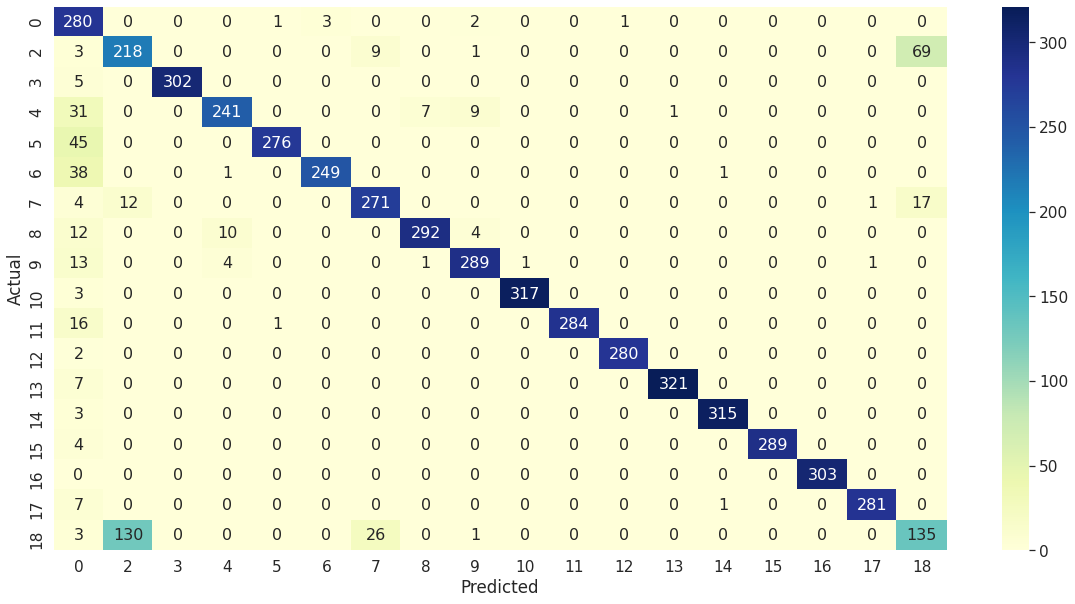

In [ ]:
plt.figure(figsize = (20,10))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm_dt, annot=True, annot_kws={"size": 16}, fmt="d",cmap="YlGnBu");

## Random Forest

In [ ]:
######## Geração do Modelo ########
rf_model = RandomForestClassifier(max_depth=30,min_samples_leaf=1,min_samples_split=8,n_estimators=400, random_state=42)
rf_model.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
######## Predição ########
y_pred_prob = rf_model.predict_proba(X_valid)
df_geral_rf, df_por_rotulo_rf, df_cm_rf,grafico_rf = metricas(y_pred_prob,y_valid_log,'Randon Forest')

In [ ]:
df_geral_rf.to_csv("df_geral_rf.csv")

In [ ]:
df_por_rotulo_rf.to_csv("df_por_rotulo_rf.csv")

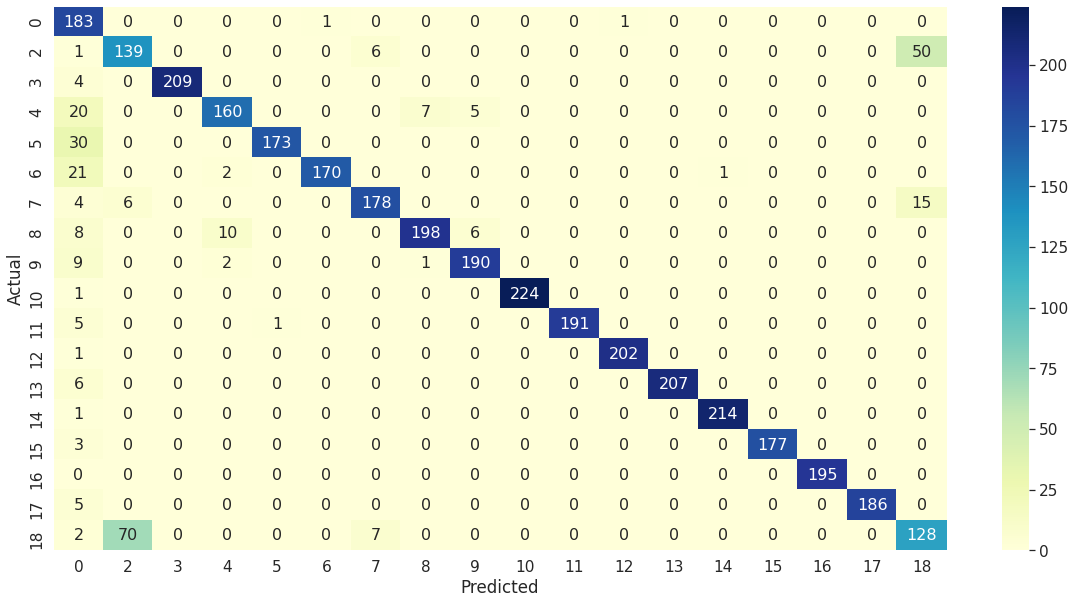

In [ ]:
plt.figure(figsize = (20,10))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm_rf, annot=True, annot_kws={"size": 16}, fmt="d",cmap="YlGnBu");

## Convolution Neural Network - FCN 


### Arquitetura FCN

In [ ]:
def cnn_fnc(X_train,Y_train):
  
  x_train, x_test, y_train, y_test = train_test_split(X_train,Y_train,test_size=0.20, random_state=42,shuffle=False)

  nb_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))

  # transform the labels from integers to one hot vectors
  enc = OneHotEncoder(categories='auto')
  enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
  y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
  y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

  y_true = np.argmax(y_test, axis=1)

  x_train = x_train.reshape((x_train.shape[0], x_train.shape[1],1))
  x_test = x_test.reshape((x_test.shape[0], x_test.shape[1],1))

  input_shape = x_train.shape[1:]

  input_layer = keras.layers.Input(input_shape)

  conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding='same')(input_layer)
  conv1 = keras.layers.BatchNormalization()(conv1)
  conv1 = keras.layers.Activation(activation='relu')(conv1)

  conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
  conv2 = keras.layers.BatchNormalization()(conv2)
  conv2 = keras.layers.Activation('relu')(conv2)

  conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
  conv3 = keras.layers.BatchNormalization()(conv3)
  conv3 = keras.layers.Activation('relu')(conv3)

  gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)

  output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

  model = keras.models.Model(inputs=input_layer, outputs=output_layer)

  model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(),metrics=['accuracy'])

  batch_size = 16
  nb_epochs = 20

  mini_batch_size = int(min(x_train.shape[0]/10, batch_size))

  hist = model.fit(x_train, y_train,validation_data=(x_train,y_train),batch_size=mini_batch_size, epochs=nb_epochs,verbose=1)

  return model,hist

### Predição

In [ ]:
####### Criação do modelo ########
model, hist = cnn_fnc(X_train,Y_train)

Epoch 1/20
728/728 [==============================] - 7s 8ms/step - loss: 0.7225 - accuracy: 0.7673 - val_loss: 0.4563 - val_accuracy: 0.8493
Epoch 2/20
728/728 [==============================] - 5s 7ms/step - loss: 0.4725 - accuracy: 0.8398 - val_loss: 0.3762 - val_accuracy: 0.8806
Epoch 3/20
728/728 [==============================] - 5s 7ms/step - loss: 0.3899 - accuracy: 0.8719 - val_loss: 0.3394 - val_accuracy: 0.8826
Epoch 4/20
728/728 [==============================] - 6s 8ms/step - loss: 0.3521 - accuracy: 0.8801 - val_loss: 0.2897 - val_accuracy: 0.8954
Epoch 5/20
728/728 [==============================] - 5s 7ms/step - loss: 0.3248 - accuracy: 0.8899 - val_loss: 0.3225 - val_accuracy: 0.8755
Epoch 6/20
728/728 [==============================] - 5s 7ms/step - loss: 0.3069 - accuracy: 0.8934 - val_loss: 0.2564 - val_accuracy: 0.9159
Epoch 7/20
728/728 [==============================] - 5s 7ms/step - loss: 0.3004 - accuracy: 0.8963 - val_loss: 0.2777 - val_accuracy: 0.8916
Epoch 

In [ ]:
######## Salvando o modelo #######
model_json = model.to_json()
with open("model_cnn_tcc.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_cnn_tcc.h5")

In [ ]:
######## Carregando o modelo #######
json_file = open('model_cnn_tcc.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model_cnn_tcc.h5")

In [ ]:
######## Prediçao ########
X_valid_cnn = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],1))
y_pred_prob = model.predict(X_valid_cnn)

df_geral_cnn, df_por_rotulo_cnn, df_cm_cnn,grafico_cnn = metricas(y_pred_prob,y_valid_log,'CNN')

In [ ]:
df_geral_cnn

Acurácia  Precisão  F1-Score    Recall  Log Loss       AUC
0  0.901265  0.912673  0.902451  0.901091   0.30157  0.994318

In [ ]:
df_por_rotulo_cnn

precision    recall  f1-score
0    0.571429  0.929730  0.707819
2    0.679012  0.280612  0.397112
3    1.000000  0.967136  0.983294
4    0.924419  0.828125  0.873626
5    0.977143  0.842365  0.904762
6    0.977011  0.876289  0.923913
7    0.865741  0.921182  0.892601
8    0.947867  0.900901  0.923788
9    0.945274  0.940594  0.942928
10   1.000000  0.991111  0.995536
11   0.989529  0.959391  0.974227
12   0.995025  0.985222  0.990099
13   0.995192  0.971831  0.983373
14   0.990741  0.995349  0.993039
15   0.994382  0.983333  0.988827
16   1.000000  1.000000  1.000000
17   0.983871  0.958115  0.970822
18   0.524917  0.763285  0.622047

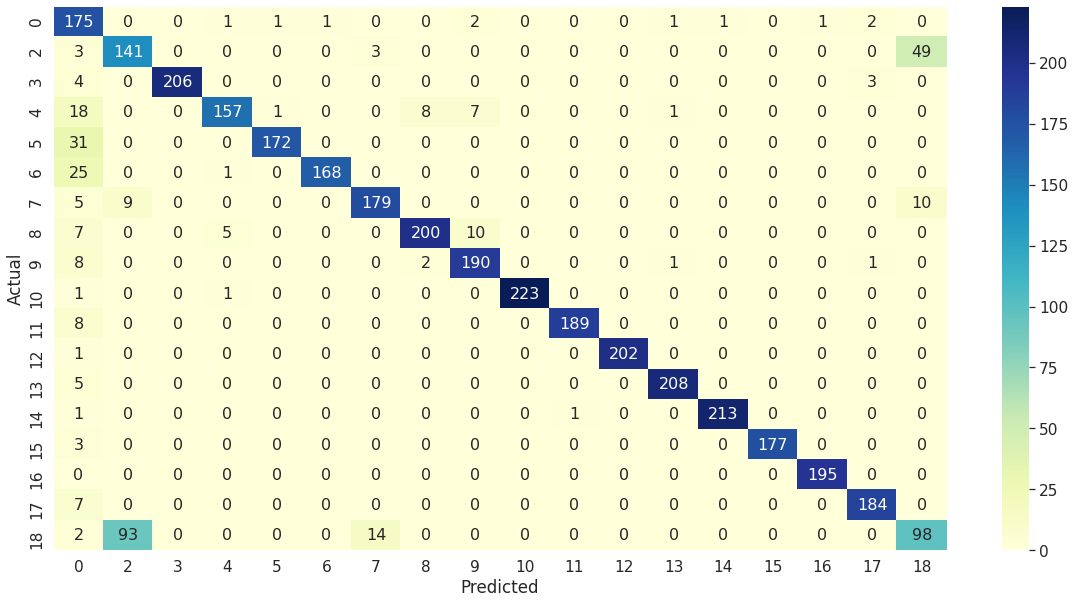

In [ ]:
plt.figure(figsize = (20,10))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm_cnn, annot=True, annot_kws={"size": 16}, fmt="d",cmap="YlGnBu");

# Comparação entre modelos

In [ ]:
new_index = ['Naive Bayes','KNN','Randon Forest',"CNN"]

## Métricas Gerais

In [ ]:
df_geral = pd.concat([df_geral_nb,df_geral_knn,df_geral_rf,df_geral_cnn], ignore_index=True)
df_geral.index = new_index
round(df_geral,3)

Acurácia  Precisão  F1-Score  Recall  Log Loss    AUC
Naive Bayes       0.855     0.861     0.850   0.855     0.903  0.988
KNN               0.846     0.860     0.848   0.843     0.775  0.984
Randon Forest     0.914     0.925     0.916   0.914     0.280  0.995
CNN               0.903     0.912     0.902   0.902     0.298  0.995

##Métricas por rótulo

In [ ]:
df_por_rotulo_nb = df_por_rotulo_nb.T
df_por_rotulo_knn = df_por_rotulo_knn.T
df_por_rotulo_rf = df_por_rotulo_rf.T
df_por_rotulo_cnn = df_por_rotulo_cnn.T
df_por_rotulo = pd.concat([df_por_rotulo_nb,df_por_rotulo_knn,df_por_rotulo_rf,df_por_rotulo_cnn], keys=new_index)
df_por_rotulo.columns.name = 'Status'
round(df_por_rotulo,2)

Status                      0     2     3     4  ...    15   16    17    18
Naive Bayes   precision  0.57  0.46  1.00  0.90  ...  1.00  1.0  1.00  0.34
              recall     1.00  0.41  0.96  0.81  ...  0.98  1.0  0.96  0.14
              f1-score   0.73  0.43  0.98  0.85  ...  0.99  1.0  0.98  0.20
KNN           precision  0.45  0.54  1.00  0.89  ...  1.00  1.0  0.59  0.52
              recall     0.77  0.55  0.94  0.77  ...  0.98  1.0  0.58  0.48
              f1-score   0.57  0.54  0.97  0.82  ...  0.99  1.0  0.58  0.50
Randon Forest precision  0.60  0.65  1.00  0.92  ...  1.00  1.0  1.00  0.66
              recall     0.99  0.71  0.98  0.83  ...  0.98  1.0  0.97  0.62
              f1-score   0.75  0.68  0.99  0.87  ...  0.99  1.0  0.99  0.64
CNN           precision  0.58  0.70  1.00  0.91  ...  1.00  1.0  0.98  0.61
              recall     0.94  0.51  0.97  0.83  ...  0.98  1.0  0.96  0.64
              f1-score   0.72  0.59  0.98  0.87  ...  0.99  1.0  0.97  0.63

[12 rows x 18 columns]

In [ ]:
df_grafico = pd.concat([grafico_nb,grafico_knn,grafico_rf,grafico_cnn])

In [ ]:
classificadores = new_index

classificador_color = {
    'CNN': '#002366', 
    'Randon Forest': '#ED2124', 
} 
figure = go.Figure()

for one_clas in classificadores:
    color = classificador_color.get(one_clas, 'lightslategrey')
    highlight = color != 'lightslategrey' 
    data_filtered = df_grafico[df_grafico['Classificador'] == one_clas]
    axis = data_filtered['index'].tolist()
    plot_data = np.array(data_filtered['f1-score'].tolist())*100
    figure.add_trace(
        go.Scatterpolar(
            r=plot_data, 
            theta=axis,
            #showlegend=highlight, 
            name=one_clas, 
            hoverinfo='name+r',
            hovertemplate='%{r:00.00f}%',
            mode='lines',
            line_color=color,
            opacity=0.8 if highlight else 0.25,
            line_shape='spline',
            line_smoothing=0.8,
            line_width=1.6 if highlight else 0.6 
        )
    )
    
title = 'Comparação da F1-Score para os classificadores CNN e Random Forest' \
        '<br><span style="font-size:10px"><i>A superioridade do Random Forest é evidenciada nas falhas 2 e 18</span></i>'

figure.update_layout(
    title_text = title,
    title_font_color = '#333333',
    title_font_size = 14,    
    polar_bgcolor='white',
    polar_radialaxis_visible=True,
    polar_radialaxis_showticklabels=True,
    polar_radialaxis_tickfont_color='darkgrey',
    polar_angularaxis_color='grey',
    polar_angularaxis_showline=False,
    polar_radialaxis_showline=False,
    polar_radialaxis_layer='below traces',
    polar_radialaxis_gridcolor='#F2F2F2',
    polar_radialaxis_range=(0,100),
    polar_radialaxis_tickvals=[25, 50, 75],
    polar_radialaxis_ticktext=['25%', '50%','75%'],
    polar_radialaxis_tickmode='array',
    polar_angularaxis_rotation = 90,
    
    legend_font_color = 'grey', # We don't want to draw attention to the legend 
    legend_itemclick = 'toggleothers', # Change the default behaviour, when click select only that trace
    legend_itemdoubleclick = 'toggle', # Change the default behaviour, when double click ommit that trace
    width = 1000, # chart size 
    height =700 # chart size
)

figure.show()